In [ ]:
# https://docs.weaviate.io/weaviate/client-libraries/python
# pip install weaviate

In [ ]:
pip uninstall weativate weaviate-client weaviate weaviate-embedded -y # remove any leftovers

In [ ]:
# pip install -U "weaviate-client>=4.5"   # 4.5+ has embedded bundled
!pip install -U weaviate-client

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 583.8/583.8 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 2.0 MB/s eta 0:00:00


In [ ]:
import weaviate
weaviate.__version__

'4.16.10'

## Remove old Weaviate DB files

In [ ]:
!rm -rf ~/.local/share/weaviate

L3 utils.py
```

import numpy as np
import networkx as nx
from random import random, randint
from math import floor, log
np.random.seed(44)

def nearest_neigbor(vec_pos,query_vec):
    nearest_neighbor_index = -1
    nearest_dist = float('inf')

    nodes = []
    edges = []
    for i in range(np.shape(vec_pos)[0]):
        nodes.append((i,{"pos": vec_pos[i,:]}))
        if i<np.shape(vec_pos)[0]-1:
            edges.append((i,i+1))
        else:
            edges.append((i,0))

        dist = np.linalg.norm(query_vec-vec_pos[i])
        if dist < nearest_dist:
            nearest_neighbor_index = i
            nearest_dist = dist
        
    G_lin = nx.Graph()
    G_lin.add_nodes_from(nodes)
    G_lin.add_edges_from(edges)

    nodes = []
    nodes.append(("*",{"pos": vec_pos[nearest_neighbor_index,:]}))
    G_best = nx.Graph()
    G_best.add_nodes_from(nodes)
    return G_lin, G_best



def layer_num(max_layers: int):
    # new element's topmost layer: notice the normalization by mL
    mL = 1.5
    layer_i = floor(-1 * log(random()) * mL)
    # ensure we don't exceed our allocated layers.
    layer_i = min(layer_i, max_layers-1)
    return layer_i
    #return randint(0,max_layers-1)




def construct_HNSW(vec_pos,m_nearest_neighbor):
    max_layers = 4

    vec_num = np.shape(vec_pos)[0]
    dist_mat = np.zeros((vec_num,vec_num))

    for i in range(vec_num):
        for j in range(i,vec_num):
            dist = np.linalg.norm(vec_pos[i,:]-vec_pos[j,:])
            dist_mat[i,j] = dist
            dist_mat[j,i] = dist

    node_layer = []
    for i in range(np.shape(vec_pos)[0]):
        node_layer.append(layer_num(max_layers))
        
    max_num_of_layers = max(node_layer) + 1 ## layer indices start from 0
    GraphArray = []
    for layer_i in range(max_num_of_layers):
        nodes = []
        edges = []
        edges_nn = []
        for i in range(np.shape(vec_pos)[0]): ## Number of Vectors
            if node_layer[i] >= layer_i:
                nodes.append((i,{"pos": vec_pos[i,:]}))

        G = nx.Graph()
        G.add_nodes_from(nodes)

        pos=nx.get_node_attributes(G,'pos')

        for i in range (len(G.nodes)):
            node_i = nodes[i][0]
            nearest_edges = -1
            nearest_distances = float('inf')
            candidate_edges = range(0,i)
            candidate_edges_indices = []
            
            #######################
            for j in candidate_edges:
                node_j = nodes[j][0]
                candidate_edges_indices.append(node_j)
            
            dist_from_node = dist_mat[node_i,candidate_edges_indices]
            num_nearest_neighbor = min(m_nearest_neighbor,i) ### Add note comment
            
            if num_nearest_neighbor > 0:
                indices = np.argsort(dist_from_node)
                for nn_i in range(num_nearest_neighbor):
                        edges_nn.append((node_i,candidate_edges_indices[indices[nn_i]]))
            
            for j in candidate_edges:
                node_j = nodes[j][0]            
                dist = np.linalg.norm(pos[node_i]-pos[node_j])
                if dist < nearest_distances:
                    nearest_edges = node_j
                    nearest_distances = dist
            
            if nearest_edges != -1:
                edges.append((node_i,nearest_edges))

        G.add_edges_from(edges_nn)

        GraphArray.append(G)
        
    return GraphArray


## Search the Graph
def search_HNSW(GraphArray,G_query):
    max_layers = len(GraphArray)
    G_top_layer = GraphArray[max_layers - 1]
    num_nodes = G_top_layer.number_of_nodes()
    entry_node_r = randint(0,num_nodes-1)
    nodes_list = list(G_top_layer.nodes)
    entry_node_index = nodes_list[entry_node_r]
    #entry_node_index = 26

    SearchPathGraphArray = []
    EntryGraphArray = []
    for l_i in range(max_layers):
        layer_i = max_layers - l_i - 1
        G_layer = GraphArray[layer_i]
        
        G_entry = nx.Graph()
        nodes = []
        p = G_layer.nodes[entry_node_index]['pos']
        nodes.append((entry_node_index,{"pos": p}))
        G_entry.add_nodes_from(nodes)
        
        nearest_node_layer = entry_node_index
        nearest_distance_layer = np.linalg.norm( G_layer.nodes[entry_node_index]['pos'] - G_query.nodes['Q']['pos'])
        current_node_index = entry_node_index

        G_path_layer = nx.Graph()
        nodes_path = []
        p = G_layer.nodes[entry_node_index]['pos']
        nodes_path.append((entry_node_index,{"pos": p}))

        cond = True
        while cond:
            nearest_node_current = -1
            nearest_distance_current = float('inf')
            for neihbor_i in G_layer.neighbors(current_node_index):
                vec1 = G_layer.nodes[neihbor_i]['pos']
                vec2 = G_query.nodes['Q']['pos']
                dist = np.linalg.norm( vec1 - vec2)
                if dist < nearest_distance_current:
                    nearest_node_current = neihbor_i
                    nearest_distance_current = dist
            
            if nearest_distance_current < nearest_distance_layer:
                nearest_node_layer = nearest_node_current
                nearest_distance_layer = nearest_distance_current
                nodes_path.append((nearest_node_current,{"pos": G_layer.nodes[nearest_node_current]['pos']}))
            else:
                cond = False
        
        entry_node_index = nearest_node_layer

        G_path_layer.add_nodes_from(nodes_path)
        SearchPathGraphArray.append(G_path_layer)
        EntryGraphArray.append(G_entry)

    SearchPathGraphArray.reverse()
    EntryGraphArray.reverse()

    return SearchPathGraphArray, EntryGraphArray

```

In [ ]:
# utils.py
import numpy as np
import networkx as nx
from random import random, randint
from math import floor, log
np.random.seed(44)

def nearest_neigbor(vec_pos,query_vec):
    nearest_neighbor_index = -1
    nearest_dist = float('inf')

    nodes = []
    edges = []
    for i in range(np.shape(vec_pos)[0]):
        nodes.append((i,{"pos": vec_pos[i,:]}))
        if i<np.shape(vec_pos)[0]-1:
            edges.append((i,i+1))
        else:
            edges.append((i,0))

        dist = np.linalg.norm(query_vec-vec_pos[i])
        if dist < nearest_dist:
            nearest_neighbor_index = i
            nearest_dist = dist

    G_lin = nx.Graph()
    G_lin.add_nodes_from(nodes)
    G_lin.add_edges_from(edges)

    nodes = []
    nodes.append(("*",{"pos": vec_pos[nearest_neighbor_index,:]}))
    G_best = nx.Graph()
    G_best.add_nodes_from(nodes)
    return G_lin, G_best



def layer_num(max_layers: int):
    # new element's topmost layer: notice the normalization by mL
    mL = 1.5
    layer_i = floor(-1 * log(random()) * mL)
    # ensure we don't exceed our allocated layers.
    layer_i = min(layer_i, max_layers-1)
    return layer_i
    #return randint(0,max_layers-1)




def construct_HNSW(vec_pos,m_nearest_neighbor):
    max_layers = 4

    vec_num = np.shape(vec_pos)[0]
    dist_mat = np.zeros((vec_num,vec_num))

    for i in range(vec_num):
        for j in range(i,vec_num):
            dist = np.linalg.norm(vec_pos[i,:]-vec_pos[j,:])
            dist_mat[i,j] = dist
            dist_mat[j,i] = dist

    node_layer = []
    for i in range(np.shape(vec_pos)[0]):
        node_layer.append(layer_num(max_layers))

    max_num_of_layers = max(node_layer) + 1 ## layer indices start from 0
    GraphArray = []
    for layer_i in range(max_num_of_layers):
        nodes = []
        edges = []
        edges_nn = []
        for i in range(np.shape(vec_pos)[0]): ## Number of Vectors
            if node_layer[i] >= layer_i:
                nodes.append((i,{"pos": vec_pos[i,:]}))

        G = nx.Graph()
        G.add_nodes_from(nodes)

        pos=nx.get_node_attributes(G,'pos')

        for i in range (len(G.nodes)):
            node_i = nodes[i][0]
            nearest_edges = -1
            nearest_distances = float('inf')
            candidate_edges = range(0,i)
            candidate_edges_indices = []

            #######################
            for j in candidate_edges:
                node_j = nodes[j][0]
                candidate_edges_indices.append(node_j)

            dist_from_node = dist_mat[node_i,candidate_edges_indices]
            num_nearest_neighbor = min(m_nearest_neighbor,i) ### Add note comment

            if num_nearest_neighbor > 0:
                indices = np.argsort(dist_from_node)
                for nn_i in range(num_nearest_neighbor):
                        edges_nn.append((node_i,candidate_edges_indices[indices[nn_i]]))

            for j in candidate_edges:
                node_j = nodes[j][0]
                dist = np.linalg.norm(pos[node_i]-pos[node_j])
                if dist < nearest_distances:
                    nearest_edges = node_j
                    nearest_distances = dist

            if nearest_edges != -1:
                edges.append((node_i,nearest_edges))

        G.add_edges_from(edges_nn)

        GraphArray.append(G)

    return GraphArray


## Search the Graph
def search_HNSW(GraphArray,G_query):
    max_layers = len(GraphArray)
    G_top_layer = GraphArray[max_layers - 1]
    num_nodes = G_top_layer.number_of_nodes()
    entry_node_r = randint(0,num_nodes-1)
    nodes_list = list(G_top_layer.nodes)
    entry_node_index = nodes_list[entry_node_r]
    #entry_node_index = 26

    SearchPathGraphArray = []
    EntryGraphArray = []
    for l_i in range(max_layers):
        layer_i = max_layers - l_i - 1
        G_layer = GraphArray[layer_i]

        G_entry = nx.Graph()
        nodes = []
        p = G_layer.nodes[entry_node_index]['pos']
        nodes.append((entry_node_index,{"pos": p}))
        G_entry.add_nodes_from(nodes)

        nearest_node_layer = entry_node_index
        nearest_distance_layer = np.linalg.norm( G_layer.nodes[entry_node_index]['pos'] - G_query.nodes['Q']['pos'])
        current_node_index = entry_node_index

        G_path_layer = nx.Graph()
        nodes_path = []
        p = G_layer.nodes[entry_node_index]['pos']
        nodes_path.append((entry_node_index,{"pos": p}))

        cond = True
        while cond:
            nearest_node_current = -1
            nearest_distance_current = float('inf')
            for neihbor_i in G_layer.neighbors(current_node_index):
                vec1 = G_layer.nodes[neihbor_i]['pos']
                vec2 = G_query.nodes['Q']['pos']
                dist = np.linalg.norm( vec1 - vec2)
                if dist < nearest_distance_current:
                    nearest_node_current = neihbor_i
                    nearest_distance_current = dist

            if nearest_distance_current < nearest_distance_layer:
                nearest_node_layer = nearest_node_current
                nearest_distance_layer = nearest_distance_current
                nodes_path.append((nearest_node_current,{"pos": G_layer.nodes[nearest_node_current]['pos']}))
            else:
                cond = False

        entry_node_index = nearest_node_layer

        G_path_layer.add_nodes_from(nodes_path)
        SearchPathGraphArray.append(G_path_layer)
        EntryGraphArray.append(G_entry)

    SearchPathGraphArray.reverse()
    EntryGraphArray.reverse()

    return SearchPathGraphArray, EntryGraphArray

# Approximate Nearest Neighbors

In [ ]:
from random import random, randint
from math import floor, log
import networkx as nx
import numpy as np
import matplotlib as mtplt
from matplotlib import pyplot as plt
# from utils import *

vec_num = 40 # Number of vectors (nodes)
dim = 2 ## Dimention. Set to be 2. All the graph plots are for dim 2. If changed, then plots should be commented.
m_nearest_neighbor = 2 # M Nearest Neigbor used in construction of the Navigable Small World (NSW)

vec_pos = np.random.uniform(size=(vec_num, dim))

### Query Vector

In [ ]:
## Query
query_vec = [0.5, 0.5]

nodes = []
nodes.append(("Q",{"pos": query_vec}))

G_query = nx.Graph()
G_query.add_nodes_from(nodes)

print("nodes = ", nodes, flush=True)

pos_query=nx.get_node_attributes(G_query,'pos')

nodes =  [('Q', {'pos': [0.5, 0.5]})]


## Brute Force

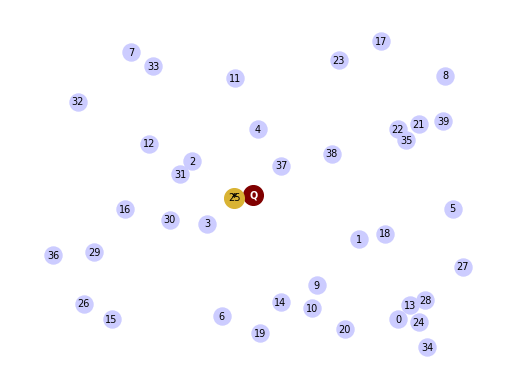

In [ ]:
(G_lin, G_best) = nearest_neigbor(vec_pos,query_vec)

pos_lin=nx.get_node_attributes(G_lin,'pos')
pos_best=nx.get_node_attributes(G_best,'pos')

fig, axs = plt.subplots()

nx.draw(G_lin, pos_lin, with_labels=True, node_size=150, node_color=[[0.8,0.8,1]], width=0.0, font_size=7, ax = axs)
nx.draw(G_query, pos_query, with_labels=True, node_size=200, node_color=[[0.5,0,0]], font_color='white', width=0.5, font_size=7, font_weight='bold', ax = axs)
nx.draw(G_best, pos_best, with_labels=True, node_size=200, node_color=[[0.85,0.7,0.2]], width=0.5, font_size=7, font_weight='bold', ax = axs)

### HNSW Construction

layer_i =  3


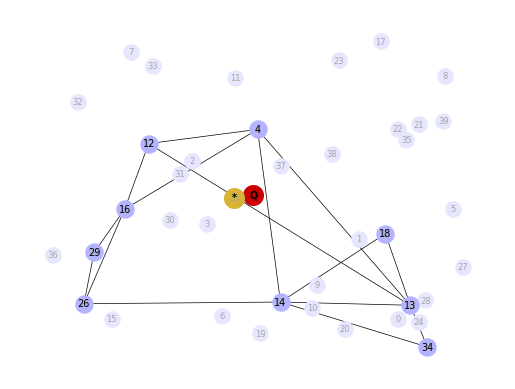

layer_i =  2


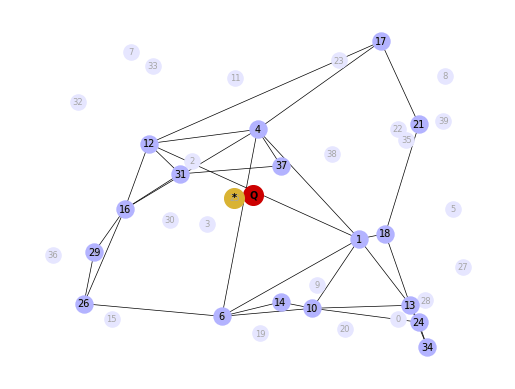

layer_i =  1


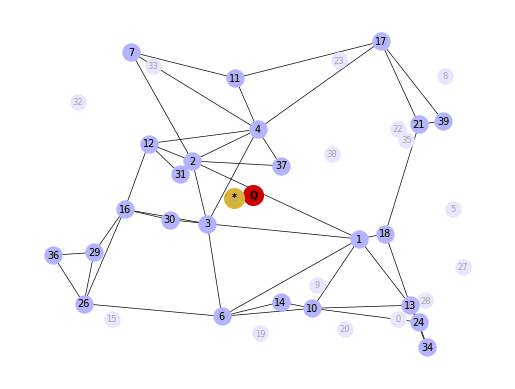

layer_i =  0


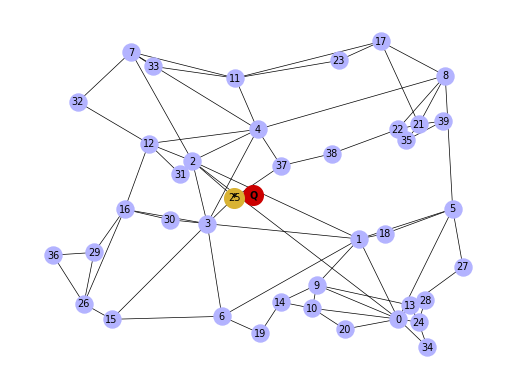

In [ ]:
GraphArray = construct_HNSW(vec_pos,m_nearest_neighbor)

for layer_i in range(len(GraphArray)-1,-1,-1):
    fig, axs = plt.subplots()

    print("layer_i = ", layer_i)

    if layer_i>0:
        pos_layer_0 = nx.get_node_attributes(GraphArray[0],'pos')
        nx.draw(GraphArray[0], pos_layer_0, with_labels=True, node_size=120, node_color=[[0.9,0.9,1]], width=0.0, font_size=6, font_color=(0.65,0.65,0.65), ax = axs)

    pos_layer_i = nx.get_node_attributes(GraphArray[layer_i],'pos')
    nx.draw(GraphArray[layer_i], pos_layer_i, with_labels=True, node_size=150, node_color=[[0.7,0.7,1]], width=0.5, font_size=7, ax = axs)
    nx.draw(G_query, pos_query, with_labels=True, node_size=200, node_color=[[0.8,0,0]], width=0.5, font_size=7, font_weight='bold', ax = axs)
    nx.draw(G_best, pos_best, with_labels=True, node_size=200, node_color=[[0.85,0.7,0.2]], width=0.5, font_size=7, font_weight='bold', ax = axs)
    plt.show()

### HNSW Search

layer_i =  3


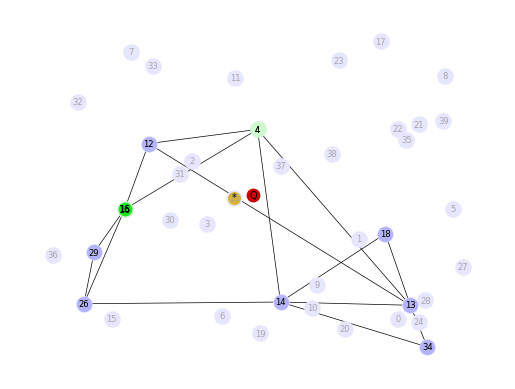

layer_i =  2


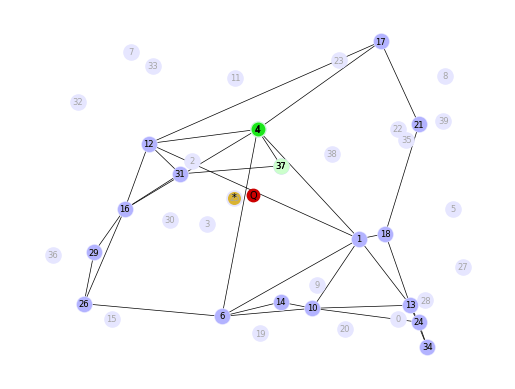

layer_i =  1


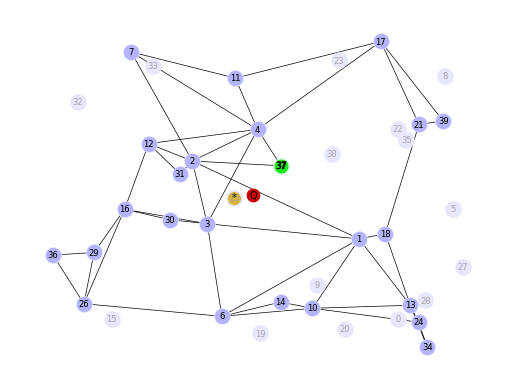

layer_i =  0


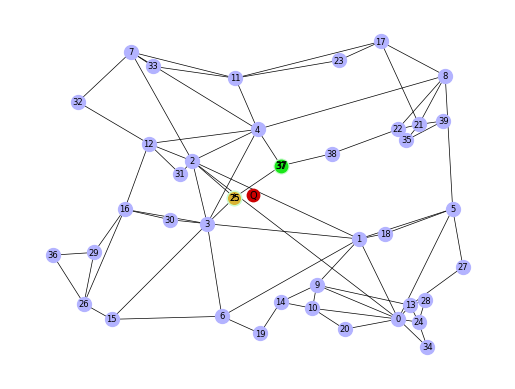

In [ ]:
(SearchPathGraphArray, EntryGraphArray) = search_HNSW(GraphArray,G_query)

for layer_i in range(len(GraphArray)-1,-1,-1):
    fig, axs = plt.subplots()

    print("layer_i = ", layer_i)
    G_path_layer = SearchPathGraphArray[layer_i]
    pos_path = nx.get_node_attributes(G_path_layer,'pos')
    G_entry = EntryGraphArray[layer_i]
    pos_entry = nx.get_node_attributes(G_entry,'pos')

    if layer_i>0:
            pos_layer_0 = nx.get_node_attributes(GraphArray[0],'pos')
            nx.draw(GraphArray[0], pos_layer_0, with_labels=True, node_size=120, node_color=[[0.9,0.9,1]], width=0.0, font_size=6, font_color=(0.65,0.65,0.65), ax = axs)

    pos_layer_i = nx.get_node_attributes(GraphArray[layer_i],'pos')
    nx.draw(GraphArray[layer_i], pos_layer_i, with_labels=True, node_size=100, node_color=[[0.7,0.7,1]], width=0.5, font_size=6, ax = axs)
    nx.draw(G_path_layer, pos_path, with_labels=True, node_size=110, node_color=[[0.8,1,0.8]], width=0.5, font_size=6, ax = axs)
    nx.draw(G_query, pos_query, with_labels=True, node_size=80, node_color=[[0.8,0,0]], width=0.5, font_size=7, ax = axs)
    nx.draw(G_best, pos_best, with_labels=True, node_size=70, node_color=[[0.85,0.7,0.2]], width=0.5, font_size=7, ax = axs)
    nx.draw(G_entry, pos_entry, with_labels=True, node_size=80, node_color=[[0.1,0.9,0.1]], width=0.5, font_size=7, ax = axs)
    plt.show()

## Pure Vector Search - with a vector database

I'll help you fix this Weaviate error. The issue is that you're using Weaviate client v4 but with v3 syntax. Let me search for the correct v4 syntax for embedded Weaviate.Let me search for more specific information about the correct v4 syntax with embedded options.Based on my search results, I can see the issue clearly. You're using Weaviate client v4, but trying to use the v3 API syntax. The v4 client has completely changed the API. Here's how to fix your code:

The Problem
Your error occurs because weaviate.Client() has been removed in v4 and replaced with weaviate.WeaviateClient()
1
2
. Additionally, the v4 client is instantiated by the WeaviateClient object, which is the main entry point for all API operations
3
.



In [ ]:
# # weaviate v3
# import weaviate, json
# from weaviate import EmbeddedOptions

# client = weaviate.Client(
#     embedded_options=EmbeddedOptions(),
# )

# client.is_ready()


# /tmp/ipython-input-1351885577.py4: DeprecationWarning:
# Python client v3 `weaviate.Client(...)` has been removed.

# Upgrade your code to use Python client v4 `weaviate.WeaviateClient` connections and methods.
#     - For Python Client v4 usage, see: https://weaviate.io/developers/weaviate/client-libraries/python
#     - For code migration, see: https://weaviate.io/developers/weaviate/client-libraries/python/v3_v4_migration

# If you have to use v3 code, install the v3 client and pin the v3 dependency in your requirements file: `weaviate-client>=3.26.7;<4.0.0`
#   client = weaviate.Client(
# ---------------------------------------------------------------------------
# TypeError                                 Traceback (most recent call last)
# /tmp/ipython-input-1351885577.py in <cell line: 0>()
#       2 from weaviate import EmbeddedOptions
#       3
# ----> 4 client = weaviate.Client(
#       5     embedded_options=EmbeddedOptions(),
#       6 )

# TypeError: Client.__init__() got an unexpected keyword argument 'embedded_options'

In [ ]:
# weaviate v4
import weaviate
from weaviate.embedded import EmbeddedOptions
import weaviate.classes as wvc  # <— gives you Configure, DataType, etc. under wvc.config


# Create client with embedded options
client = weaviate.WeaviateClient(
    embedded_options=EmbeddedOptions() # run weaviate vector DB locally
)

# IMPORTANT: You must call connect() when using WeaviateClient directly
client.connect()

# Check if it's ready
print("Ready?", client.is_ready())

# Close when done
# client.close()

INFO:weaviate-client:Started /root/.cache/weaviate-embedded: process ID 5294


Ready? True


In [ ]:
# client.close()

In [ ]:
# resetting the schema. CAUTION: This will delete your collection
# if client.schema.exists("MyCollection"):
#     client.schema.delete_class("MyCollection")

# # Use client.collections.create() to create the collection in v4
# client.collections.create(
#     name="MyCollection",
#     vectorizer_config=None,
#     vector_index_config={
#         "vectorizer": "none", # Explicitly set vectorizer to "none" here
#         "distance": "cosine"
#     }
# )


# (Optional) Reset the collection if it already exists (v4 way)
# WARNING: This deletes the collection and its data.
try:
    client.collections.delete("MyCollection")  # v4 delete API
except Exception:
    # Ignore if it doesn't exist
    pass
# (Docs: delete with `client.collections.delete(collection_name)`)  # [4](https://docs.weaviate.io/weaviate/manage-collections/collection-operations)



# Create a collection with:
# - BYO vectors (no vectorizer) -> Configure.Vectors.self_provided()
# - HNSW index w/ cosine distance
client.collections.create(
    name="MyCollection",
    # vectorIndexType
    # https://github.com/weaviate/weaviate/blob/main/test/acceptance_with_go_client/named_vectors_tests/test_suits/named_vectors_vector_index_types.go
    # flat, hnsw
    vector_config=wvc.config.Configure.Vectors.self_provided(  # no vectorizer
        vector_index_config = wvc.config.Configure.VectorIndex.hnsw(distance_metric = wvc.config.VectorDistances.COSINE
        )
    ),
    # properties=[wvc.config.Property(name="text", data_type=wvc.config.DataType.TEXT)],
)

print("Successfully created the schema.")

Successfully created the schema.


### Import the Data

In [ ]:
data = [
   {
      "title": "First Object",
      "foo": 99,
      "vector": [0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
   },
   {
      "title": "Second Object",
      "foo": 77,
      "vector": [0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
   },
   {
      "title": "Third Object",
      "foo": 55,
      "vector": [0.3, 0.1, -0.1, -0.3, -0.5, -0.7]
   },
   {
      "title": "Fourth Object",
      "foo": 33,
      "vector": [0.4, 0.41, 0.42, 0.43, 0.44, 0.45]
   },
   {
      "title": "Fifth Object",
      "foo": 11,
      "vector": [0.5, 0.5, 0, 0, 0, 0]
   },
]

In [ ]:
# client.batch.configure(batch_size=10)  # Configure batch

# # Batch import all objects
# # yes batch is an overkill for 5 objects, but it is recommended for large volumes of data
# with client.batch as batch:
#   for item in data:

#       properties = {
#          "title": item["title"],
#          "foo": item["foo"],
#       }

#       # the call that performs data insert
#       client.batch.add_data_object(
#          class_name="MyCollection",
#          data_object=properties,
#          vector=item["vector"] # your vector embeddings go here
#       )


# ---------------------------------------------------------------------------
# AttributeError                            Traceback (most recent call last)
# /tmp/ipython-input-3562589237.py in <cell line: 0>()
# ----> 1 client.batch.configure(batch_size=10)  # Configure batch
#       2
#       3 # Batch import all objects
#       4 # yes batch is an overkill for 5 objects, but it is recommended for large volumes of data
#       5 with client.batch as batch:

# AttributeError: '_BatchClientWrapper' object has no attribute 'configure'

AttributeError: '_BatchClientWrapper' object has no attribute 'configure'

In [ ]:
coll = client.collections.get("MyCollection")

# Fixed-size batch; you can also use dynamic() modes
# COLLECTION PROCESSES IN BATCHES OF 10 (ADDED TO BATCH LARGE DATASETS SAFELY)
with coll.batch.fixed_size(batch_size=10) as batch:
    # THEN PROCESS 1-BY-1 FROM UR DATASET
    for item in data:
        # ADDING TO THE 'COLLECTION' DIRECTLY
        batch.add_object(
            properties={"title": item["title"], "foo": item["foo"]}, # metadata/text
            vector=item["vector"],  # BYO/Bring Your Own vector
        )
    # You can inspect errors if needed:
    # print("errors:", batch.number_errors)

# otherwise weaviate creates its own vector embeddings????
# and we can get those vector embeddings????


In [ ]:
# After the context, you can also check which ones failed:
print(coll.batch.failed_objects)

[]


In [ ]:
# # Check number of objects
# response = (
#     client.query
#     .aggregate("MyCollection")
#     .with_meta_count()
#     .do()
# )

# print(response)

In [ ]:
# Count how many objects exist
from weaviate.classes.query import Metrics

coll = client.collections.get("MyCollection")
agg = coll.aggregate.over_all(total_count=True)
print("total_count:", agg.total_count)

total_count: 5


In [ ]:
coll.aggregate.over_all(total_count=False)

AggregateReturn(properties={}, total_count=0)

In [ ]:
coll.aggregate.over_all(total_count=True)

AggregateReturn(properties={}, total_count=5)

### Query Weaviate: Vector Search (vector embeddings) (Input: Vector Values, Output: Nearest Vectors)

In [ ]:
# response = (
#     client.query
#     .get("MyCollection", ["title"])
#     .with_near_vector({
#         "vector": [-0.012, 0.021, -0.23, -0.42, 0.5, 0.5]
#     })
#     .with_limit(2) # limit the output to only 2
#     .do()
# )

# result = response["data"]["Get"]["MyCollection"]
# print(json.dumps(result, indent=2))

In [ ]:
# response = (
#     client.query
#     .get("MyCollection", ["title"])
#     .with_near_vector({
#         "vector": [-0.012, 0.021, -0.23, -0.42, 0.5, 0.5]
#     })
#     .with_limit(2) # limit the output to only 2
#     .with_additional(["distance", "vector, id"])    # EXTRA COMPARED TO ABOVE - GET METADATA
#     .do()
# )

# result = response["data"]["Get"]["MyCollection"]
# print(json.dumps(result, indent=2))

#### Retrieve 2 nearest vectors. No Medatata

In [ ]:
import weaviate.classes.query as wq

query_vec = [-0.012, 0.021, -0.23, -0.42, 0.5, 0.5]

resp = coll.query.near_vector(
    near_vector=query_vec,
    limit=2,
    return_metadata=wq.MetadataQuery(distance=True)  # distance smaller = closer
)

# NO 'METADATA'
for o in resp.objects:
    print({"title": o.properties.get("title"), "distance": o.metadata.distance})

{'title': 'Second Object', 'distance': 0.6506307125091553}
{'title': 'Fourth Object', 'distance': 0.8072028756141663}


In [ ]:
resp.objects

[GenerativeObject(uuid=_WeaviateUUIDInt('66cbd456-1634-4ef4-a7ac-2e6e2e163ce7'), metadata=MetadataReturn(creation_time=None, last_update_time=None, distance=0.6506307125091553, certainty=None, score=None, explain_score=None, is_consistent=None, rerank_score=None), properties={'title': 'Second Object', 'foo': 77.0}, references=None, vector={}, collection='MyCollection'),
 GenerativeObject(uuid=_WeaviateUUIDInt('cbd3c7f0-279b-4b9f-89f4-07c524199d7a'), metadata=MetadataReturn(creation_time=None, last_update_time=None, distance=0.8072028756141663, certainty=None, score=None, explain_score=None, is_consistent=None, rerank_score=None), properties={'title': 'Fourth Object', 'foo': 33.0}, references=None, vector={}, collection='MyCollection')]

#### Retrieve 2 nearest vectors. With Medatata

In [ ]:
# GET METADATA (eg UUID, vector)

# UPDATED 'resp' code block
resp = coll.query.near_vector(
    near_vector=query_vec,
    limit=2,
    # return_metadata=wq.MetadataQuery(distance=True, vector=True)  # uuid returned by default - syntax not for weaviate v4
    include_vector=True,                                  # ADDED
    return_metadata=wq.MetadataQuery(distance=True)

)

# # UPDATED METADATA PRINTOUT
# for o in resp.objects:
#     print({
#         "title": o.properties.get("title"),
#         "distance": o.metadata.distance,
#         "uuid": o.uuid,
#         "vector_dim": len(o.metadata.vector) if o.metadata.vector is not None else None
#     })

for o in resp.objects:
    vec = o.vector.get("default") if o.vector else None
    print({
        "title": o.properties.get("title"),
        "distance": o.metadata.distance,  # cosine: smaller = closer
        "uuid": o.uuid,                   # UUIDs are returned by default in v4
        "vector_dim": len(vec) if vec is not None else None
    })

{'title': 'Second Object', 'distance': 0.6506307125091553, 'uuid': _WeaviateUUIDInt('66cbd456-1634-4ef4-a7ac-2e6e2e163ce7'), 'vector_dim': 6}
{'title': 'Fourth Object', 'distance': 0.8072028756141663, 'uuid': _WeaviateUUIDInt('cbd3c7f0-279b-4b9f-89f4-07c524199d7a'), 'vector_dim': 6}


In [ ]:
resp.objects

[GenerativeObject(uuid=_WeaviateUUIDInt('66cbd456-1634-4ef4-a7ac-2e6e2e163ce7'), metadata=MetadataReturn(creation_time=None, last_update_time=None, distance=0.6506307125091553, certainty=None, score=None, explain_score=None, is_consistent=None, rerank_score=None), properties={'title': 'Second Object', 'foo': 77.0}, references=None, vector={'default': [0.20000000298023224, 0.30000001192092896, 0.4000000059604645, 0.5, 0.6000000238418579, 0.699999988079071]}, collection='MyCollection'),
 GenerativeObject(uuid=_WeaviateUUIDInt('cbd3c7f0-279b-4b9f-89f4-07c524199d7a'), metadata=MetadataReturn(creation_time=None, last_update_time=None, distance=0.8072028756141663, certainty=None, score=None, explain_score=None, is_consistent=None, rerank_score=None), properties={'title': 'Fourth Object', 'foo': 33.0}, references=None, vector={'default': [0.4000000059604645, 0.4099999964237213, 0.41999998688697815, 0.4300000071525574, 0.4399999976158142, 0.44999998807907104]}, collection='MyCollection')]

#### Retrieve all nearest vectors. SORTED in ASC distance (nearest 1st)!

In [ ]:
# WHAT IF I DONT LIMIT TO TOP 2 VECTORS - ARE THEY SORTED? YES, IN ASCENDING ORDER OF DISTANCE!
# GET METADATA (eg UUID, vector)

# UPDATED 'resp' code block
resp = coll.query.near_vector(
    near_vector=query_vec,
    # limit=2,    # DONT LIMIT HERE
    # return_metadata=wq.MetadataQuery(distance=True, vector=True)  # uuid returned by default - syntax not for weaviate v4
    include_vector=True,                                  # ADDED
    return_metadata=wq.MetadataQuery(distance=True)

)

# # UPDATED METADATA PRINTOUT
# for o in resp.objects:
#     print({
#         "title": o.properties.get("title"),
#         "distance": o.metadata.distance,
#         "uuid": o.uuid,
#         "vector_dim": len(o.metadata.vector) if o.metadata.vector is not None else None
#     })

for o in resp.objects:
    vec = o.vector.get("default") if o.vector else None
    print({
        "title": o.properties.get("title"),
        "distance": o.metadata.distance,  # cosine: smaller = closer
        "uuid": o.uuid,                   # UUIDs are returned by default in v4
        "vector_dim": len(vec) if vec is not None else None
    })

{'title': 'Second Object', 'distance': 0.6506307125091553, 'uuid': _WeaviateUUIDInt('66cbd456-1634-4ef4-a7ac-2e6e2e163ce7'), 'vector_dim': 6}
{'title': 'Fourth Object', 'distance': 0.8072028756141663, 'uuid': _WeaviateUUIDInt('cbd3c7f0-279b-4b9f-89f4-07c524199d7a'), 'vector_dim': 6}
{'title': 'First Object', 'distance': 0.8284496068954468, 'uuid': _WeaviateUUIDInt('67709103-327a-4c4b-8894-e12601fc5524'), 'vector_dim': 6}
{'title': 'Fifth Object', 'distance': 0.9925509691238403, 'uuid': _WeaviateUUIDInt('84039c0d-ee15-40e5-9ac2-aeb779b3b7e4'), 'vector_dim': 6}
{'title': 'Third Object', 'distance': 1.5462952852249146, 'uuid': _WeaviateUUIDInt('e3377bd6-fd03-4819-8434-dee44ccdb9bf'), 'vector_dim': 6}


In [ ]:
resp.objects

[GenerativeObject(uuid=_WeaviateUUIDInt('66cbd456-1634-4ef4-a7ac-2e6e2e163ce7'), metadata=MetadataReturn(creation_time=None, last_update_time=None, distance=0.6506307125091553, certainty=None, score=None, explain_score=None, is_consistent=None, rerank_score=None), properties={'title': 'Second Object', 'foo': 77.0}, references=None, vector={'default': [0.20000000298023224, 0.30000001192092896, 0.4000000059604645, 0.5, 0.6000000238418579, 0.699999988079071]}, collection='MyCollection'),
 GenerativeObject(uuid=_WeaviateUUIDInt('cbd3c7f0-279b-4b9f-89f4-07c524199d7a'), metadata=MetadataReturn(creation_time=None, last_update_time=None, distance=0.8072028756141663, certainty=None, score=None, explain_score=None, is_consistent=None, rerank_score=None), properties={'title': 'Fourth Object', 'foo': 33.0}, references=None, vector={'default': [0.4000000059604645, 0.4099999964237213, 0.41999998688697815, 0.4300000071525574, 0.4399999976158142, 0.44999998807907104]}, collection='MyCollection'),
 Gen

### [Extra] Use HF vectoriser to create vectors, then store in Weaviate vectorDB

In [ ]:
client.close()

In [ ]:
# client2.close()

In [ ]:
from google.colab import userdata
HF_TOKEN = userdata.get('HF_TOKEN')

In [ ]:
# client2 = weaviate.connect_to_custom(
#     http_host="127.0.0.1", http_port=8079, http_secure=False,
#     grpc_host="127.0.0.1", grpc_port=50050, grpc_secure=False,
#     headers={"X-HuggingFace-Api-Key": HF_TOKEN},   # <-- pass HF key here
#     # auth_credentials=Auth.api_key("...")         # if your server requires auth
# )

# print("Ready?", client2.is_ready())



# --- 1) Connect: try existing embedded (ports 8079/50050), else start a new one
def connect_or_start_embedded():
    try:
        # Try to connect to an already-running embedded instance
        return weaviate.connect_to_custom(
            http_host="127.0.0.1", http_port=8079, http_secure=False,
            grpc_host="127.0.0.1", grpc_port=50050, grpc_secure=False,
            headers={"X-HuggingFace-Api-Key": HF_TOKEN},
        )
    except Exception:
        # If that fails, start a new embedded server with headers
        return weaviate.connect_to_embedded(
            # version="1.26.5",  # optional: pin for repeatability
            headers={"X-HuggingFace-Api-Key": HF_TOKEN},
            environment_variables={"LOG_LEVEL": "error"},
        )


client2 = connect_or_start_embedded()
assert client2.is_ready(), "Weaviate is not ready"


INFO:weaviate-client:Started /root/.cache/weaviate-embedded: process ID 31550


In [ ]:
# --- 2) (Re)create the HF-vectorized collection
COLL = "CollWeaviateVector"
try:
    client2.collections.delete(COLL)
except Exception:
    pass


In [ ]:
import os
import weaviate
import weaviate.classes as wvc
import weaviate.classes.query as wq
from weaviate.classes.config import Configure, Property, DataType, VectorDistances

# # HF_TOKEN = os.getenv("HUGGINGFACE_APIKEY")  # e.g., "hf_..."
# client2 = weaviate.connect_to_embedded(
#     # Pin a version if you want; otherwise latest stable is used
#     # version="1.26.5",
#     headers={"X-HuggingFace-Api-Key": HF_TOKEN},          # <- pass headers here
#     environment_variables={"LOG_LEVEL": "error"},         # optional: reduce logs
# )

# Create a collection that auto-vectorizes with Hugging Face
client2.collections.create(
    name="CollWeaviateVector",
    vector_config=Configure.Vectors.text2vec_huggingface(
        model="sentence-transformers/all-MiniLM-L6-v2",
        source_properties=["title"],
        vectorize_collection_name=False,
    ),
    properties=[
        Property(name="title", data_type=DataType.TEXT),
        Property(name="foo",   data_type=DataType.INT),
    ],
)

coll = client2.collections.get("CollWeaviateVector")

In [ ]:
# Insert WITHOUT explicit vectors (Weaviate will embed 'title' automatically)
data = [
    {"title": "First Object",  "foo": 99},
    {"title": "Second Object", "foo": 77},
    {"title": "Third Object",  "foo": 55},
    {"title": "Fourth Object", "foo": 33},
    {"title": "Fifth Object",  "foo": 11},
]
coll.data.insert_many([wvc.data.DataObject(properties=d) for d in data])

BatchObjectReturn(_all_responses=[UUID('85d146e7-fc74-442d-867e-5582ea2a9537'), UUID('81acb6a9-cd24-4881-834d-96f145015213'), UUID('58a44802-a57f-46cf-a5fe-23aa87ba64e9'), UUID('535e58d3-92b2-4c71-ab81-75121dafd17d'), UUID('26f5c9f1-63e6-4ff0-b89b-f7ca21cf8fb2')], elapsed_seconds=0.18213653564453125, errors={}, uuids={0: UUID('85d146e7-fc74-442d-867e-5582ea2a9537'), 1: UUID('81acb6a9-cd24-4881-834d-96f145015213'), 2: UUID('58a44802-a57f-46cf-a5fe-23aa87ba64e9'), 3: UUID('535e58d3-92b2-4c71-ab81-75121dafd17d'), 4: UUID('26f5c9f1-63e6-4ff0-b89b-f7ca21cf8fb2')}, has_errors=False)

In [ ]:
# Vector search using near_text (Weaviate embeds the query text with the same model)
resp = coll.query.near_text(
    query="similar to Fourth Object",
    limit=3,
    include_vector=True,                              # <-- add this
    return_metadata=wq.MetadataQuery(distance=True),  # still get distance
)


for o in resp.objects:
    print({"title": o.properties["title"], "distance": o.metadata.distance})

{'title': 'Fourth Object', 'distance': 0.20009839534759521}
{'title': 'Third Object', 'distance': 0.3366837501525879}
{'title': 'Fifth Object', 'distance': 0.361652672290802}


In [ ]:
for o in resp.objects:
    vec = o.vector.get("default") if o.vector else None
    print({
        "title": o.properties["title"],
        "distance": round(o.metadata.distance, 6),
        "vector_dim": len(vec) if vec else None
    })


{'title': 'Fourth Object', 'distance': 0.200098, 'vector_dim': 384}
{'title': 'Third Object', 'distance': 0.336684, 'vector_dim': 384}
{'title': 'Fifth Object', 'distance': 0.361653, 'vector_dim': 384}


In [ ]:
len(resp.objects)

3

In [ ]:
resp.objects

[Object(uuid=_WeaviateUUIDInt('535e58d3-92b2-4c71-ab81-75121dafd17d'), metadata=MetadataReturn(creation_time=None, last_update_time=None, distance=0.20009839534759521, certainty=None, score=None, explain_score=None, is_consistent=None, rerank_score=None), properties={'title': 'Fourth Object', 'foo': 33}, references=None, vector={'default': [0.09170138835906982, 0.0356433242559433, -0.04934227094054222, -0.03408027067780495, -0.07054862380027771, 0.01458530779927969, 0.06469433009624481, -0.014271602034568787, 0.050880469381809235, -0.008471596986055374, 0.007082887459546328, -0.07411663979291916, -0.04376974329352379, 0.04829888045787811, 0.005942201241850853, 0.024313149973750114, -0.016686318442225456, 0.10002455115318298, -0.13856296241283417, -0.004889015108346939, 0.00609007989987731, -0.10630007833242416, 0.03594003617763519, 0.0003742456319741905, -0.05350176990032196, 0.08153282105922699, -0.0016961367800831795, -0.026804441586136818, 0.02920793741941452, -0.09970853477716446, 

In [ ]:
# check 1 vector
resp.objects[0].__dict__.keys()

dict_keys(['uuid', 'metadata', 'properties', 'references', 'vector', 'collection'])

In [ ]:
# check 1 vector
resp.objects[0].__dict__

{'uuid': _WeaviateUUIDInt('535e58d3-92b2-4c71-ab81-75121dafd17d'),
 'metadata': MetadataReturn(creation_time=None, last_update_time=None, distance=0.20009839534759521, certainty=None, score=None, explain_score=None, is_consistent=None, rerank_score=None),
 'properties': {'title': 'Fourth Object', 'foo': 33},
 'references': None,
 'vector': {'default': [0.09170138835906982,
   0.0356433242559433,
   -0.04934227094054222,
   -0.03408027067780495,
   -0.07054862380027771,
   0.01458530779927969,
   0.06469433009624481,
   -0.014271602034568787,
   0.050880469381809235,
   -0.008471596986055374,
   0.007082887459546328,
   -0.07411663979291916,
   -0.04376974329352379,
   0.04829888045787811,
   0.005942201241850853,
   0.024313149973750114,
   -0.016686318442225456,
   0.10002455115318298,
   -0.13856296241283417,
   -0.004889015108346939,
   0.00609007989987731,
   -0.10630007833242416,
   0.03594003617763519,
   0.0003742456319741905,
   -0.05350176990032196,
   0.08153282105922699,
   

In [ ]:
len(resp.objects[0].vector["default"]) # MiniLM generate 384 dims embeddings

384

In [ ]:
# client.collections.create(
#     name="CollWeaviateVector",
#     # Bring-your-own vectors; Weaviate will not embed for you
#     vector_config=wvc.config.Configure.Vectors.self_provided(
#         vector_index_config=wvc.config.Configure.VectorIndex.hnsw(
#             distance_metric=wvc.config.VectorDistances.COSINE
#         )
#     ),
#     # Properties for production hygiene
#     properties=[
#         wvc.config.Property(name="title", data_type=wvc.config.DataType.TEXT),
#         wvc.config.Property(name="foo",   data_type=wvc.config.DataType.INT),
#     ],
# )


In [ ]:
# # delete collection
# # client.collections.delete("CollWeaviateVector")



# # delete objects inside ur collection
# from weaviate.classes.query import Filter

# coll = client.collections.get("CollWeaviateVector")

# # Delete all objects that have any title (wildcard match)
# resp = coll.data.delete_many(
#     where=Filter.by_property("title").like("*")
# )
# print(resp)  # shows matches/deletes count

DeleteManyReturn(failed=0, matches=0, objects=None, successful=0)


In [ ]:
# # sanity check after deleting objects
# # Count should be 0 if collection is empty
# print(coll.aggregate.over_all(total_count=True).total_count)

0


In [ ]:
# coll = client.collections.get("CollWeaviateVector")


In [ ]:
# # ----- Insert with vectors -----
# # Small dataset -> insert_many is simplest; for large, use coll.batch.fixed_size()
# objs = [
#     wvc.data.DataObject(
#         properties={"title": item["title"], "foo": item["foo"]},
#         # vector=item["vector"]
#     )
#     for item in data
# ]
# coll.data.insert_many(objs)


BatchObjectReturn(_all_responses=[UUID('40ff4e7f-073c-479c-a893-61da236e5d41'), UUID('8b9e4762-5ba7-4c54-9f92-1b12f8bbdac9'), UUID('be0d6b38-9f8a-4402-887a-ac56b7e443c3'), UUID('0a808c89-3db3-47ab-a1be-64048660f190'), UUID('5958dc05-edc7-4cea-a70c-d463eba6808d')], elapsed_seconds=0.003826141357421875, errors={}, uuids={0: UUID('40ff4e7f-073c-479c-a893-61da236e5d41'), 1: UUID('8b9e4762-5ba7-4c54-9f92-1b12f8bbdac9'), 2: UUID('be0d6b38-9f8a-4402-887a-ac56b7e443c3'), 3: UUID('0a808c89-3db3-47ab-a1be-64048660f190'), 4: UUID('5958dc05-edc7-4cea-a70c-d463eba6808d')}, has_errors=False)

In [ ]:
# # ----- Nearest-vector search -----
# # Example query vector (choose anything of dim=6)
# query_vec = [0.35, 0.35, 0.35, 0.35, 0.35, 0.30]

# resp = coll.query.near_vector(
#     near_vector=query_vec,
#     limit=3,
#     include_vector=True,                             # return vectors
#     return_metadata=wq.MetadataQuery(distance=True)  # return distances
# )

# print("Top-3 nearest to query_vec:")
# for o in resp.objects:
#     vec = o.vector.get("default") if o.vector else None
#     print({
#         "uuid": o.uuid,
#         "title": o.properties.get("title"),
#         "foo": o.properties.get("foo"),
#         "distance": round(o.metadata.distance, 6),   # cosine distance: smaller = closer
#         "vector_dim": len(vec) if vec is not None else None
#     })


Top-3 nearest to query_vec:


In [ ]:
# resp.objects

[]

In [ ]:
# #  Optionally: "nearest to an existing object" (near_object)
# anchor_uuid = resp.objects[0].uuid
# resp2 = coll.query.near_object(
#     near_object=anchor_uuid,
#     limit=3,
#     return_metadata=wq.MetadataQuery(distance=True)
# )
# print("\nTop-3 nearest to anchor object:")
# for o in resp2.objects:
#     print({"title": o.properties.get("title"), "distance": round(o.metadata.distance, 6)})


Top-3 nearest to anchor object:
{'title': 'First Object', 'distance': 0.0}
{'title': 'Fourth Object', 'distance': 0.000806}
{'title': 'Second Object', 'distance': 0.065066}


In [ ]:
# resp.objects

[GenerativeObject(uuid=_WeaviateUUIDInt('be32f868-ecdd-4495-8ae0-e2d4c881c714'), metadata=MetadataReturn(creation_time=None, last_update_time=None, distance=0.0014839768409729004, certainty=None, score=None, explain_score=None, is_consistent=None, rerank_score=None), properties={'title': 'First Object', 'foo': 99}, references=None, vector={'default': [0.10000000149011612, 0.10000000149011612, 0.10000000149011612, 0.10000000149011612, 0.10000000149011612, 0.10000000149011612]}, collection='CollWeaviateVector'),
 GenerativeObject(uuid=_WeaviateUUIDInt('f1489d49-8685-473f-b253-1c22b222c1d4'), metadata=MetadataReturn(creation_time=None, last_update_time=None, distance=0.003720581531524658, certainty=None, score=None, explain_score=None, is_consistent=None, rerank_score=None), properties={'title': 'Fourth Object', 'foo': 33}, references=None, vector={'default': [0.4000000059604645, 0.4099999964237213, 0.41999998688697815, 0.4300000071525574, 0.4399999976158142, 0.44999998807907104]}, collec

### Vector Search with filters (Input: Vector Values, Output: Nearest Vectors)

In [ ]:
# response = (
#     client.query
#     .get("MyCollection", ["title", "foo"])
#     .with_near_vector({
#         "vector": [-0.012, 0.021, -0.23, -0.42, 0.5, 0.5]
#     })
#     .with_additional(["distance, id"]) # output the distance of the query vector to the objects in the database
#     .with_where({
#         "path": ["foo"],
#         "operator": "GreaterThan",
#         "valueNumber": 44
#     })
#     .with_limit(2) # limit the output to only 2
#     .do()
# )

# result = response["data"]["Get"]["MyCollection"]
# print(json.dumps(result, indent=2))

#### Filter, then limit to 2 nearest vectors

In [ ]:
from weaviate.classes.query import Filter

resp = coll.query.near_vector(
    near_vector=query_vec,
    limit=2,    # if i limit to '2' vectors, I limit to the top 2 vectors, with the lowest distance
    filters=Filter.by_property("foo").greater_than(44),
    return_metadata=wq.MetadataQuery(distance=True)
)

for o in resp.objects:
    print({"title": o.properties.get("title"), "foo": o.properties.get("foo"), "distance": o.metadata.distance})


{'title': 'Second Object', 'foo': 77.0, 'distance': 0.6506307125091553}
{'title': 'First Object', 'foo': 99.0, 'distance': 0.8284496068954468}


In [ ]:
resp.objects

[GenerativeObject(uuid=_WeaviateUUIDInt('66cbd456-1634-4ef4-a7ac-2e6e2e163ce7'), metadata=MetadataReturn(creation_time=None, last_update_time=None, distance=0.6506307125091553, certainty=None, score=None, explain_score=None, is_consistent=None, rerank_score=None), properties={'title': 'Second Object', 'foo': 77.0}, references=None, vector={}, collection='MyCollection'),
 GenerativeObject(uuid=_WeaviateUUIDInt('67709103-327a-4c4b-8894-e12601fc5524'), metadata=MetadataReturn(creation_time=None, last_update_time=None, distance=0.8284496068954468, certainty=None, score=None, explain_score=None, is_consistent=None, rerank_score=None), properties={'title': 'First Object', 'foo': 99.0}, references=None, vector={}, collection='MyCollection')]

#### Filter, no limit to 'n' nearest vectors

In [ ]:
from weaviate.classes.query import Filter

resp = coll.query.near_vector(
    near_vector=query_vec,
    # limit=2, # what if i dont limit to 2 vectors - the third vector with a further distance can be retrieved
    filters=Filter.by_property("foo").greater_than(44),
    return_metadata=wq.MetadataQuery(distance=True)
)

for o in resp.objects:
    print({"title": o.properties.get("title"), "foo": o.properties.get("foo"), "distance": o.metadata.distance})


{'title': 'Second Object', 'foo': 77.0, 'distance': 0.6506307125091553}
{'title': 'First Object', 'foo': 99.0, 'distance': 0.8284496068954468}
{'title': 'Third Object', 'foo': 55.0, 'distance': 1.5462952852249146}


In [ ]:
resp.objects

[GenerativeObject(uuid=_WeaviateUUIDInt('66cbd456-1634-4ef4-a7ac-2e6e2e163ce7'), metadata=MetadataReturn(creation_time=None, last_update_time=None, distance=0.6506307125091553, certainty=None, score=None, explain_score=None, is_consistent=None, rerank_score=None), properties={'title': 'Second Object', 'foo': 77.0}, references=None, vector={}, collection='MyCollection'),
 GenerativeObject(uuid=_WeaviateUUIDInt('67709103-327a-4c4b-8894-e12601fc5524'), metadata=MetadataReturn(creation_time=None, last_update_time=None, distance=0.8284496068954468, certainty=None, score=None, explain_score=None, is_consistent=None, rerank_score=None), properties={'title': 'First Object', 'foo': 99.0}, references=None, vector={}, collection='MyCollection'),
 GenerativeObject(uuid=_WeaviateUUIDInt('e3377bd6-fd03-4819-8434-dee44ccdb9bf'), metadata=MetadataReturn(creation_time=None, last_update_time=None, distance=1.5462952852249146, certainty=None, score=None, explain_score=None, is_consistent=None, rerank_sco

### nearObject Example (Input: UUID, Output: Nearest Vectors)

In [ ]:
# response = (
#     client.query
#     .get("MyCollection", ["title"])
#     .with_near_object({ # the id of the the search object
#         "id": result[0]['_additional']['id']
#     })
#     .with_limit(3)
#     .with_additional(["distance"])
#     .do()
# )

# result = response["data"]["Get"]["MyCollection"]
# print(json.dumps(result, indent=2))

In [ ]:
# Use the first result's UUID as the anchor
anchor_uuid = resp.objects[0].uuid

resp2 = coll.query.near_object(
    near_object=anchor_uuid,          # UUID string
    limit=3,
    return_metadata=wq.MetadataQuery(distance=True)
)

for o in resp2.objects:
    print({"title": o.properties.get("title"), "distance": o.metadata.distance})


{'title': 'Second Object', 'distance': 0.0}
{'title': 'Fourth Object', 'distance': 0.05157369375228882}
{'title': 'First Object', 'distance': 0.06506645679473877}


In [ ]:
resp2.objects

[Object(uuid=_WeaviateUUIDInt('66cbd456-1634-4ef4-a7ac-2e6e2e163ce7'), metadata=MetadataReturn(creation_time=None, last_update_time=None, distance=0.0, certainty=None, score=None, explain_score=None, is_consistent=None, rerank_score=None), properties={'title': 'Second Object', 'foo': 77.0}, references=None, vector={}, collection='MyCollection'),
 Object(uuid=_WeaviateUUIDInt('cbd3c7f0-279b-4b9f-89f4-07c524199d7a'), metadata=MetadataReturn(creation_time=None, last_update_time=None, distance=0.05157369375228882, certainty=None, score=None, explain_score=None, is_consistent=None, rerank_score=None), properties={'title': 'Fourth Object', 'foo': 33.0}, references=None, vector={}, collection='MyCollection'),
 Object(uuid=_WeaviateUUIDInt('67709103-327a-4c4b-8894-e12601fc5524'), metadata=MetadataReturn(creation_time=None, last_update_time=None, distance=0.06506645679473877, certainty=None, score=None, explain_score=None, is_consistent=None, rerank_score=None), properties={'title': 'First Obje

# Summary of Weaviate v4 updated syntax

Local/embedded weaviate client
```
client = weaviate.WeaviateClient(embedded_options=EmbeddedOptions())
client.connect()
```

Create collection (no vectorizer, HNSW+cosine)
```
import weaviate.classes as wvc

client.collections.create(
    name="MyCollection",
    vector_config=wvc.config.Configure.Vectors.self_provided(
        vector_index_config=wvc.config.Configure.VectorIndex.hnsw(
            distance_metric=wvc.config.VectorDistances.COSINE
        )
    ),
)
```



Insert objects (few)
```
import weaviate.classes as wvc

coll = client.collections.get("MyCollection")
objs = [
    wvc.data.DataObject(
        properties={"title": item["title"], "foo": item["foo"]},
        vector=item["vector"],
    )
    for item in data
]
coll.data.insert_many(objs)

```

Insert objects (many) - so insert in batches
```
coll = client.collections.get("MyCollection")

with coll.batch.fixed_size(batch_size=200) as batch:
    for item in data:
        batch.add_object(
            properties={"title": item["title"], "foo": item["foo"]},
            vector=item["vector"],
        )
# Inspect after:
# print("failed:", coll.batch.failed_objects)
```


Vector search (+distance, +vector)
```
import weaviate.classes.query as wq

resp = coll.query.near_vector(
    near_vector=[...],
    limit=5,
    include_vector=True,                        # vectors here
    return_metadata=wq.MetadataQuery(distance=True)  # and metadata here
)
for o in resp.objects:
    print(o.uuid, o.properties, o.metadata.distance)
```



Filter
```
from weaviate.classes.query import Filter
resp = coll.query.near_vector(
    near_vector=[...],
    limit=5,
    filters=Filter.by_property("foo").greater_than(44)
)
```

Aggregate count
```
print(coll.aggregate.over_all(total_count=True).total_count)
```


Full/E2E example
```
# 1) connect (embedded)
import weaviate
from weaviate.embedded import EmbeddedOptions
client = weaviate.WeaviateClient(embedded_options=EmbeddedOptions())
client.connect()

# 2) create collection (BYO vectors)
import weaviate.classes as wvc
client.collections.create(
    name="MyCollection",
    vector_config=wvc.config.Configure.Vectors.self_provided(
        vector_index_config=wvc.config.Configure.VectorIndex.hnsw(
            distance_metric=wvc.config.VectorDistances.COSINE
        )
    ),
)

# 3) insert data
coll = client.collections.get("MyCollection")
coll.data.insert_many([
    wvc.data.DataObject(properties={"title": "First",  "foo": 99}, vector=[0.1, 0.1, 0.1, 0.1, 0.1, 0.1]),
    wvc.data.DataObject(properties={"title": "Second", "foo": 77}, vector=[0.2, 0.3, 0.4, 0.5, 0.6, 0.7]),
])

# 4) query
import weaviate.classes.query as wq
qvec = [-0.012, 0.021, -0.23, -0.42, 0.5, 0.5]

resp = coll.query.near_vector(
    near_vector=qvec,
    limit=2,
    include_vector=True,
    return_metadata=wq.MetadataQuery(distance=True)
)
for o in resp.objects:
    print(o.uuid, o.properties.get("title"), o.metadata.distance, len(o.vector.get("default", [])))

```


Tips
* Use include_vector=True (not MetadataQuery(vector=True)) when you need vectors in responses.
* Keep vectors as list[float] or np.float32/64—avoid object dtypes.
* **For deterministic IDs, use generate_uuid5() before insert** if you might re‑upsert the same payload.
* Check coll.batch.failed_objects after big imports.
* Prefer collection API (coll.query..., coll.data...) over raw GraphQL for type-safety and gRPC speed.

